# Import libraries



In [13]:
import cv2
from google.colab.patches import cv2_imshow
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import mean_squared_error
import copy

In [14]:
SUB_IMAGE_SIZE = 20
TARGET_SIZE = 20
SCALE = 4
STRIDE = 3

# Load dataset
Training set -> T91

Test set -> set14, Set5

In [ ]:
# Unzip datasets
!unzip "/content/T91.zip" -d "/content/"
!unzip "/content/Set14.zip" -d "/content/"
!unzip "/content/Set5.zip" -d "/content/"

In [18]:
def normalize(img):
  return img.astype(np.float32) / 255
    
def modcrop(img):
  size = img.shape
  size -= np.mod(size, SCALE)
  img = img[0:size[0], 0:size[1], 0]
  return img

def modcrop_color(image):
  size = image.shape
  size -= np.mod(size, SCALE)
  image = image[0:size[0], 0:size[1], :]
  return image


def unNormalize(img):
  img = img * 255
  img[img > 255] = 255
  img[img < 0] = 0
  return img.astype(np.uint8)


# Load images function
def load_images(filepath):
  print("\nLoading train images...")
  
  lr_images = []
  hr_images = []

  for file in glob.glob(filepath + "*.bmp"):
    #Read image
    img = cv2.imread(file)

    #From BGR to YCB_CR -> crop -> normalize between 0 and 1
    img = normalize(modcrop(cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)))

    img_rot = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  
    # Create low-resolution and interpolated-low-resoution images
    lr_img = cv2.resize(img, None, fx = 1.0/SCALE ,fy = 1.0/SCALE, interpolation = cv2.INTER_CUBIC)
    
    lr_img_rot = cv2.resize(img_rot, None, fx = 1.0/SCALE ,fy = 1.0/SCALE, interpolation = cv2.INTER_CUBIC)

    #Add images
    hr_images.append(img)
    lr_images.append(lr_img)

    hr_images.append(img_rot)
    lr_images.append(lr_img_rot)

  print("\nDataset loaded!")
  return np.array(hr_images), np.array(lr_images)


def make_sub_data(input_array, target_array):
    sub_input_sequence = []
    sub_target_sequence = []

    # For this network there is no padding because SUB_IMAGE_SIZE = TARGET_SIZE
    padding = int(abs(SUB_IMAGE_SIZE - TARGET_SIZE) // 2)

    for i in range(len(input_array)):
        h, w = input_array[i].shape
        input = input_array[i]
        target = target_array[i]

        # Create sub-images
        for x in range(0, h - SUB_IMAGE_SIZE, STRIDE):
            for y in range(0, w - SUB_IMAGE_SIZE, STRIDE):
                sub_input = input[x : x + SUB_IMAGE_SIZE, y : y + SUB_IMAGE_SIZE]
                sub_target = target[(x + padding)*SCALE : (x + padding + TARGET_SIZE)*SCALE, (y + padding)*SCALE : (y + padding + TARGET_SIZE)*SCALE]

                sub_input = sub_input.reshape((SUB_IMAGE_SIZE, SUB_IMAGE_SIZE, 1)) 
                sub_target = sub_target.reshape([TARGET_SIZE*SCALE, TARGET_SIZE*SCALE, 1])

        
                sub_input_sequence.append(sub_input)
                sub_target_sequence.append(sub_target)
        
    print(len(sub_input_sequence))

    return np.array(sub_input_sequence), np.array(sub_target_sequence)

In [19]:
filepath_T91= '/content/T91/'
filepath_Set14= '/content/Set14/'
filepath_Set5= '/content/Set5/'


# LOAD DATASET
train_hr, train_lr = load_images(filepath_T91)

input, target = make_sub_data(train_lr, train_hr)



Loading train images...

Dataset loaded!
36204


# Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, None, None, 48)    1248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 16)    784       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 216)   31320     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 48)    10416     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, None, None, 1)     3889      
Total params: 49,977
Trainable params: 49,977
Non-trainable params: 0
__________________________________________________

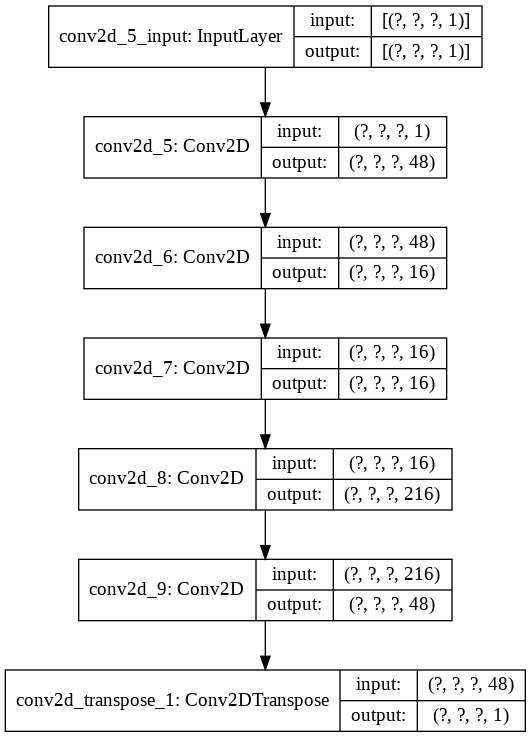

In [20]:
fsrcnn = tf.keras.models.Sequential()

# Feature extraction layer
fsrcnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size = (5, 5), kernel_initializer='he_uniform',
                     activation='relu', padding='same', input_shape=(None, None, 1)))

# Shrinking layer
fsrcnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size = (1, 1),
                     activation='relu', padding='same'))

#Non linear Mapping layers
fsrcnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size = (3, 3),
                     activation='relu', padding='same'))

fsrcnn.add(tf.keras.layers.Conv2D(filters=216, kernel_size = (3, 3),
                     activation='relu', padding='same'))

# Expanding layer
fsrcnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size = (1, 1),
                     activation='relu', padding='same'))

# Deconvolution layer
fsrcnn.add(tf.keras.layers.Conv2DTranspose(1, (9,9), strides = (SCALE,SCALE), padding='same', activation='linear'))


fsrcnn.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001), loss='mean_squared_error')

fsrcnn.summary()
tf.keras.utils.plot_model(fsrcnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
history = fsrcnn.fit(input, target, epochs=100, batch_size=64, 
                          shuffle=True, validation_split=0.1)

Epoch 1/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 2/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 3/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 4/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 5/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 6/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 7/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 8/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 9/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 10/100
510/510 [==============================] - 4s 7ms/step - loss: 0.0037 - val_lo

# Evaluation

In [23]:
sum_bic_psnr = 0
sum_fsrcnn_psnr = 0
sum_bic_ssim = 0
sum_fsrcnn_ssim = 0
sum_bic_mse = 0
sum_fsrcnn_mse = 0
for idx, file in enumerate(glob.glob(filepath_Set5 + "*.bmp")):
  img = cv2.imread(file)
  gt_img = modcrop_color(cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB))
  lr_img = cv2.resize(gt_img, None, fx = 1.0/SCALE ,fy = 1.0/SCALE, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor
  ilr_img = cv2.resize(lr_img, None, fx = SCALE ,fy = SCALE, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor

  #Evaluation bicubic image
  sum_bic_psnr += peak_signal_noise_ratio(gt_img[:,:,0], ilr_img[:,:,0])
  sum_bic_ssim += structural_similarity(gt_img[:,:,0], ilr_img[:,:,0])
  sum_bic_mse += mean_squared_error(gt_img[:,:,0], ilr_img[:,:,0])

  #Prediction
  Y = np.zeros((1, lr_img.shape[0], lr_img.shape[1], 1), dtype=float)
  Y[0,:,:,0] = normalize(lr_img[:,:,0])
  prediction = fsrcnn.predict(Y, batch_size=1)

  #Image Reconstruction
  ilr_img[:,:,0] = unNormalize(prediction[0, :, :, 0])

  #Evaluation reconstructed image with FSRCNN
  sum_fsrcnn_psnr += peak_signal_noise_ratio(gt_img[:,:,0], ilr_img[:,:,0])
  sum_fsrcnn_ssim += structural_similarity(gt_img[:,:,0], ilr_img[:,:,0])
  sum_fsrcnn_mse += mean_squared_error(gt_img[:,:,0], ilr_img[:,:,0])

print("PSNR Bicubic Set5: ", sum_bic_psnr/5)
print("PSNR FSRCNN Set5: ", sum_fsrcnn_psnr/5)
print("\n")
print("SSIM Bicubic Set5: ", sum_bic_ssim/5)
print("SSIM FSRCNN Set5: ", sum_fsrcnn_ssim/5)
print("\n")
print("MSE Bicubic Set5: ", sum_bic_mse/5)
print("MSE FSRCNN Set5: ", sum_fsrcnn_mse/5)

PSNR Bicubic Set5:  26.332912321016703
PSNR FSRCNN Set5:  26.518639396763483


SSIM Bicubic Set5:  0.8027214047341407
SSIM FSRCNN Set5:  0.8083785267427201


MSE Bicubic Set5:  227.5090933772551
MSE FSRCNN Set5:  212.31630918362833


In [24]:
sum_bic_psnr = 0
sum_fsrcnn_psnr = 0
sum_bic_ssim = 0
sum_fsrcnn_ssim = 0
sum_bic_mse = 0
sum_fsrcnn_mse = 0
for idx, file in enumerate(glob.glob(filepath_Set14 + "*.bmp")):
  img = cv2.imread(file)
  gt_img = modcrop_color(cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB))
  lr_img = cv2.resize(gt_img, None, fx = 1.0/SCALE ,fy = 1.0/SCALE, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor
  ilr_img = cv2.resize(lr_img, None, fx = SCALE ,fy = SCALE, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor

  #Evaluation bicubic image
  sum_bic_psnr += peak_signal_noise_ratio(gt_img[:,:,0], ilr_img[:,:,0])
  sum_bic_ssim += structural_similarity(gt_img[:,:,0], ilr_img[:,:,0])
  sum_bic_mse += mean_squared_error(gt_img[:,:,0], ilr_img[:,:,0])

  #Prediction
  Y = np.zeros((1, lr_img.shape[0], lr_img.shape[1], 1), dtype=float)
  Y[0,:,:,0] = normalize(lr_img[:,:,0])
  prediction = fsrcnn.predict(Y, batch_size=1)
  
  #Image Reconstruction
  ilr_img[:,:,0] = unNormalize(prediction[0, :, :, 0])

  #Evaluation reconstructed image with FSRCNN
  sum_fsrcnn_psnr += peak_signal_noise_ratio(gt_img[:,:,0], ilr_img[:,:,0])
  sum_fsrcnn_ssim += structural_similarity(gt_img[:,:,0], ilr_img[:,:,0])
  sum_fsrcnn_mse += mean_squared_error(gt_img[:,:,0], ilr_img[:,:,0])

print("PSNR Bicubic Set14: ", sum_bic_psnr/14)
print("PSNR FSRCNN Set14: ", sum_fsrcnn_psnr/14)
print("\n")
print("SSIM Bicubic Set14: ", sum_bic_ssim/14)
print("SSIM FSRCNN Set14: ", sum_fsrcnn_ssim/14)
print("\n")
print("MSE Bicubic Set14: ", sum_bic_mse/14)
print("MSE FSRCNN Set14: ", sum_fsrcnn_mse/14)

PSNR Bicubic Set14:  23.388688587971103
PSNR FSRCNN Set14:  23.65408609112467


SSIM Bicubic Set14:  0.6958865134001505
SSIM FSRCNN Set14:  0.6972139422127226


MSE Bicubic Set14:  369.6916678145317
MSE FSRCNN Set14:  352.550719718261


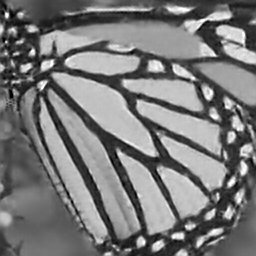

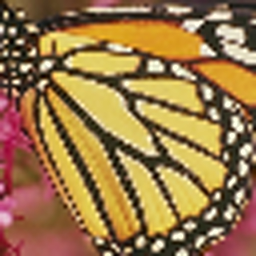

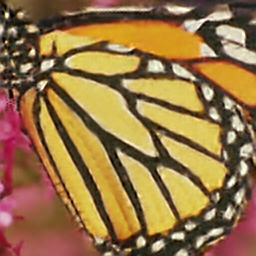

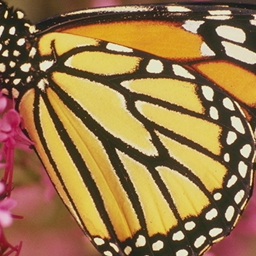

In [ ]:
img = cv2.imread("/content/Set5/butterfly_GT.bmp")
gt_img = modcrop_color(cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB))
lr_img = cv2.resize(gt_img, None, fx = 1.0/SCALE ,fy = 1.0/SCALE, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor
ilr_img = cv2.resize(lr_img, None, fx = SCALE ,fy = SCALE, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor

#Prediction
Y = np.zeros((1, lr_img.shape[0], lr_img.shape[1], 1), dtype=float)
Y[0,:,:,0] = normalize(lr_img[:,:,0])
prediction = fsrcnn.predict(Y, batch_size=1)

cv2_imshow(unNormalize(prediction[0,:,:,0]))
cv2_imshow(cv2.cvtColor(ilr_img, cv2.COLOR_YCR_CB2BGR)) 
#Image Reconstruction with VDSR
ilr_img[:,:,0] = unNormalize(prediction[0, :, :, 0])
cv2_imshow(cv2.cvtColor(ilr_img, cv2.COLOR_YCR_CB2BGR))
cv2_imshow(cv2.cvtColor(gt_img, cv2.COLOR_YCR_CB2BGR)) 